In [1]:
import numpy as np
import pandas as pd
import random as rand
import requests
import json
import re
from json import loads

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import math
import gurobipy as gp
from gurobipy import GRB

### 출발지가 같고 도착지가 다른 경우 + 탑승자가 2명& 4명인 경우도 구현한다. (ver4 추가예정)

### 주소를 입력 받으면 지오코딩api를 통해 위도 경도를 불러온 후 loc_info dictionary를 만든다. (ver3 추가예정)

In [2]:
loc_info = {
    0: ['왕십리역',127.03707847424529,37.56126476715337],
    1: ['안암역',127.02923341883837,37.586303813999805],
    2: ['신이문역',127.06738894104969,37.60177804492183],
    3: ['화랑대역',127.08353499381646,37.61982353949059]
}
loc_info

{0: ['왕십리역', 127.03707847424529, 37.56126476715337],
 1: ['안암역', 127.02923341883837, 37.586303813999805],
 2: ['신이문역', 127.06738894104969, 37.60177804492183],
 3: ['화랑대역', 127.08353499381646, 37.61982353949059]}

In [3]:
[str(loc_info[i][1]) for i in range(len(loc_info))]

['127.03707847424529',
 '127.02923341883837',
 '127.06738894104969',
 '127.08353499381646']

In [4]:
url = "https://apis.openapi.sk.com/tmap/matrix?version=1"

payload = {
    "origins": [
        {
            "lon": str(loc_info[i][1]),
            "lat": str(loc_info[i][2])
        } for i in range(len(loc_info))
    ],
    "destinations": [
        {
            "lon": str(loc_info[i][1]),
            "lat": str(loc_info[i][2])
        } for i in range(len(loc_info))
    ],
    "transportMode": "car",
    "metric": "Recommendation"
}
headers = {
    "Accept": "application/json",
    "appKey": "l7xx4d23b06a733d4f2e9c5365ca49c3431a",
    "Content-Type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)

In [5]:
jsonObj = json.loads(response.text)
jsonObj

{'meta': {'status': 'Ok',
  'message': 'Ok',
  'moduleVersion': '',
  'mapVersion': '20230221',
  'elapsedTime': 0,
  'realTimeTrafficDateTime': '',
  'patternTrafficDate': '',
  'customizationDateTime': '',
  'algorithm': '',
  'metric': 'Recommendation',
  'requestId': '8ddca8e7-d19f-45dd-b3f4-2d946a652303',
  'gasStationPriceDateTime': '',
  'transportMode': 'Car',
  'avoid': []},
 'origins': [{'link': {'linkId': '0', 'direction': 'TwoWay'},
   'poiId': '',
   'name': '',
   'coordinate': {'latitude': 37.56126476715337,
    'longitude': 127.03707847424529},
   'rpFlag': ''},
  {'link': {'linkId': '0', 'direction': 'TwoWay'},
   'poiId': '',
   'name': '',
   'coordinate': {'latitude': 37.586303813999805,
    'longitude': 127.02923341883837},
   'rpFlag': ''},
  {'link': {'linkId': '0', 'direction': 'TwoWay'},
   'poiId': '',
   'name': '',
   'coordinate': {'latitude': 37.60177804492183,
    'longitude': 127.06738894104969},
   'rpFlag': ''},
  {'link': {'linkId': '0', 'direction': 

In [6]:
duration_lst = []
distance_lst = []
for i in range(len(loc_info)**2):
    duration_lst.append(jsonObj['matrixRoutes'][i]['duration'])
    distance_lst.append(jsonObj['matrixRoutes'][i]['distance'])
duration = pd.DataFrame(np.array(duration_lst).reshape(len(loc_info),len(loc_info)))
distance = pd.DataFrame(np.array(distance_lst).reshape(len(loc_info),len(loc_info)))
print(duration)

      0    1     2     3
0     0  929  1207  1534
1   875    0  1030  1203
2  1123  806     0   839
3  1061  877  1106   990


In [7]:
addr_info = {loc_info[i][0] : {'no': i, 'lon': loc_info[i][1], 'lat': loc_info[i][2]} for i in range(len(loc_info))}
print(addr_info)

{'왕십리역': {'no': 0, 'lon': 127.03707847424529, 'lat': 37.56126476715337}, '안암역': {'no': 1, 'lon': 127.02923341883837, 'lat': 37.586303813999805}, '신이문역': {'no': 2, 'lon': 127.06738894104969, 'lat': 37.60177804492183}, '화랑대역': {'no': 3, 'lon': 127.08353499381646, 'lat': 37.61982353949059}}


dict_keys(['왕십리역', '안암역', '신이문역', '화랑대역'])


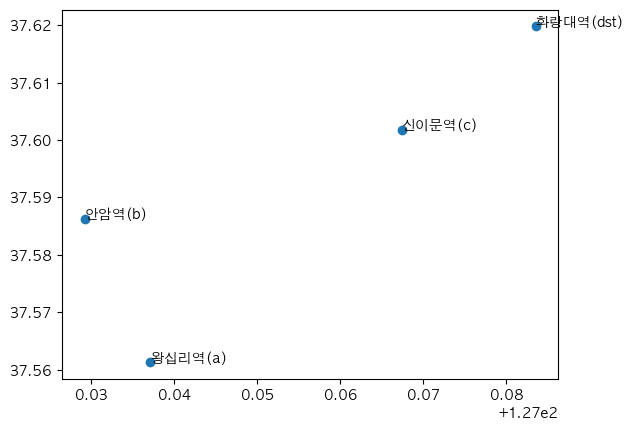

In [8]:
# same src & diff dst + 탑승인원 3명
def dist(addr):
    return (addr_info[addr]['lat']**2 + addr_info[addr]['lon']**2)**1/2

while(True):
    passenger_sample = rand.sample(list(addr_info.keys()), 4)
    a,b,c,dst = passenger_sample
    if max(dist(a), dist(b), dist(c), dist(dst))==dist(dst) or min(dist(a), dist(b), dist(c),dist(dst))==dist(dst):
        # if
        break

passenger_sample = addr_info.keys()
print(passenger_sample)
a,b,c,dst = passenger_sample
pass_2_node = {'a': a, 'b': b, 'c': c, 'dst':dst}
node_2_pass = {a: 'a', b: 'b', c: 'c', dst: 'dst'}

lat = [addr_info[addr]['lat'] for addr in passenger_sample]
lon = [addr_info[addr]['lon'] for addr in passenger_sample]
addr = [f'{pas}({node_2_pass[pas]})' for pas in passenger_sample]

fig, ax = plt.subplots()
ax.scatter(lon, lat)
for i, txt in enumerate(addr):
    ax.annotate(txt, (lon[i], lat[i]))
plt.show()

### 도착지는 고정 출발지 3곳중 어떻게 경유할지 정한다. (ver3 추가예정)

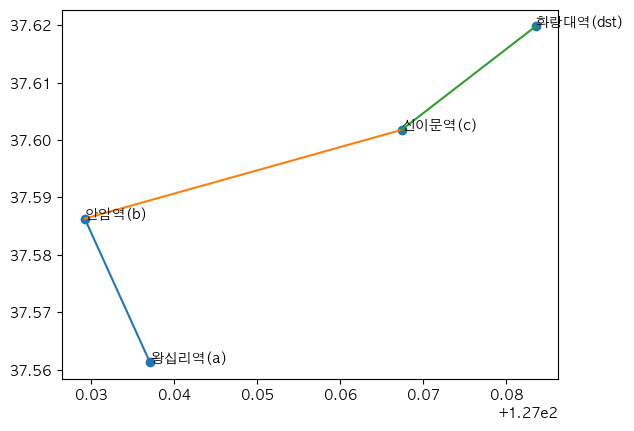

In [9]:
rout = [[addr,dist(addr)] for addr in passenger_sample]
routing = {addr: {'node':node_2_pass[addr],'no':addr_info[addr]['no']} for addr,dis in rout}

lat = [addr_info[rou]['lat'] for rou in routing]
lon = [addr_info[rou]['lon'] for rou in routing]

fig, ax = plt.subplots()
ax.scatter(lon, lat)
for i, txt in enumerate(routing):
    try:
        ax.plot([lon[i], lon[i+1]], [lat[i], lat[i+1]])
    except: pass
for i, txt in enumerate(addr):
    ax.annotate(txt, (lon[i], lat[i]))
plt.show()

In [10]:
no_routing = [addr_info[addr]['no'] for addr in routing]
print(no_routing)
new_distance = distance
new_duration = duration
print(new_duration)

[0, 1, 2, 3]
      0    1     2     3
0     0  929  1207  1534
1   875    0  1030  1203
2  1123  806     0   839
3  1061  877  1106   990


### 택시요금 크롤링하여 구현 (ver3)

In [11]:
"""
[2021년 서울 차량 통행속도 분석]에 따르면 지난해 도심 통행속도는 시속 23㎞'라는 정보를 활용해 시간을 산출하였다.
"""

def taxi_fee(meter, second):
    pay = int(4800+(meter-1600)*100/131+(second-36/160*23)*(10/3))
    if pay>0:
        return pay
    else: return int(4800)

individual_distance = [new_distance.loc[no_routing[i], no_routing[-1]] for i in range(len(no_routing)-1)]
individual_duration = [new_duration.loc[no_routing[i], no_routing[-1]] for i in range(len(no_routing)-1)]
print(individual_distance)
print(individual_duration)

routing_distance = [new_distance.loc[no_routing[num],no_routing[num+1]] for num in range(len(no_routing)-1)]
routing_duration = [new_duration.loc[no_routing[num],no_routing[num+1]] for num in range(len(no_routing)-1)]

individual_cost = [taxi_fee(individual_distance[i],individual_duration[i]) for i in range(len(no_routing)-1)]
print(individual_cost)

total_distance = sum(routing_distance)
total_duration = sum(routing_duration)

total_cost = taxi_fee(total_distance, total_duration)

routing_individual_distance = [sum(routing_distance[i:]) for i in range(len(no_routing)-1)]
routing_individual_duration = [sum(routing_duration[i:]) for i in range(len(no_routing)-1)]

delay_ratio = [(routing_individual_duration[i]-individual_duration[i])/individual_duration[i] for i in range(len(no_routing)-1)]

[14251.1, 7804.1, 6373.5]
[1534, 1203, 839]
[19553, 13528, 11223]


In [12]:
I1, I2, I3 = individual_cost
R1, R2, R3 = delay_ratio
T = total_cost
eplison = 0.03
gamma = 0.05

LB = 0.3
UB = 0.5

## matching ALGorithm
try:
  # Create a new model
  m = gp.Model('cost_optimization1')

  # Create variables
  alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
  beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

  # Set objective
  m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T, GRB.MINIMIZE)

  # Add constraint
  m.addConstr(max(R1,R2,R3)*beta-UB*alpha <= 0,'const_1')
  m.addConstr(max(R1,R2,R3)*beta-LB*alpha >= 0,'const_2')
  m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T >= 0,'const_3')

  m.addConstr(alpha <= 0.5)
  m.addConstr(alpha >= 0)
  m.addConstr(beta <= 0.5)
  m.addConstr(beta >= 0)
  #m.addConstr(gamma <= 1)

  # Optimize model
  m.optimize()

  for v in m.getVars():
    print('%s : %g' % (v.varName, v.x))
    globals()[v.varName] = v.x
  print('Obj : %g' % m.objVal)

except gp.GurobiError as e:
  print('Error code ' + str(e.errno) + ': ' + str(e))

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7 rows, 2 columns and 10 nonzeros
Model fingerprint: 0x4601e2f7
Coefficient statistics:
  Matrix range     [3e-01, 4e+04]
  Objective range  [2e+04, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+04]
Presolve removed 4 rows and 0 columns
Presolve time: 0.00s
Presolved: 3 rows, 2 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.5860167e+03   2.572663e+01   0.000000e+00      0s
       2    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  0.000000000e+00
alpha : 0.380194
beta : 0.138422
Obj : 0


In [13]:
print(f'A {alpha*100:.2f}+{beta*R1*100:.2f} => {(alpha+beta*R1)*100:.2f}% 할인')
print(f'B {alpha*100:.2f}+{beta*R2*100:.2f} => {(alpha+beta*R2)*100:.2f}% 할인')
print(f'C {alpha*100:.2f}+{beta*R3*100:.2f} => {(alpha+beta*R3)*100:.2f}% 할인')
print()
print(f'A {I1} 원 >>> {int((1-alpha+beta*R1)*I1)} 원')
print(f'B {I2} 원 >>> {int((1-alpha+beta*R2)*I2)} 원')
print(f'C {I3} 원 >>> {int((1-alpha+beta*R3)*I3)} 원')

routing_individual_cost = [int((1-alpha+beta*R1)*I1),int((1-alpha+beta*R2)*I2),int((1-alpha+beta*R3)*I3)]

A 38.02+11.41 => 49.43% 할인
B 38.02+7.66 => 45.68% 할인
C 38.02+0.00 => 38.02% 할인

A 19553 원 >>> 14349 원
B 13528 원 >>> 9421 원
C 11223 원 >>> 6956 원


In [16]:
print('혼자탔을 때')
print(f'합계 : {sum(individual_cost)} 원')
print([f'{rou} 원' for rou in individual_cost])
print([f'{rou/1000:.2f} km' for rou in individual_distance])
print([f'{rou/60:.2f} 분' for rou in individual_duration])
print()
print('동승시')
print(f'합계 : {total_cost} 원')
print([f'{rou} 원' for rou in routing_individual_cost])
print([f'{rou/1000:.2f} km' for rou in routing_individual_distance])
print([f'{rou/60:.2f} 분' for rou in routing_individual_duration])

혼자탔을 때
합계 : 44304 원
['19553 원', '13528 원', '11223 원']
['14.25 km', '7.80 km', '6.37 km']
['25.57 분', '20.05 분', '13.98 분']

동승시
합계 : 24193 원
['14349 원', '9421 원', '6956 원']
['14.81 km', '11.61 km', '6.37 km']
['46.63 분', '31.15 분', '13.98 분']
